Ricky found that for some points the disagreement is very large between
the covmat calculation and the mcvine simulation.
Here we want to see why.

Check some simple cases where we can estimate the correlation

In [1]:
workdir = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/6-check-simple-cases-1/'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/6-check-simple-cases-1


In [2]:
!which mcvine

/SNS/software/miniconda2/envs/mcvine-unstable/bin/mcvine


# Tools

In [3]:
import mcvine.cli
from mcvine_workflow.singlextal.resolution import use_covmat, use_res_comps
import numpy as np
import histogram as H, histogram.hdf as hh

In [4]:
from matplotlib import pyplot as plt, patches as mp
%matplotlib inline

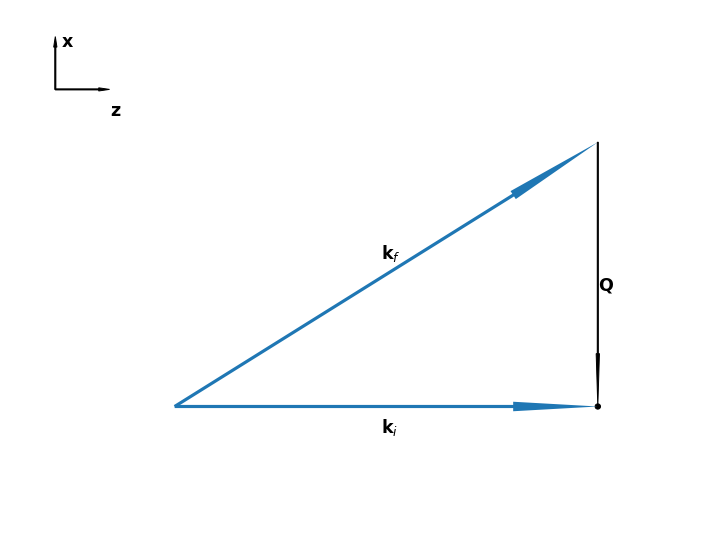

In [5]:
fig, ax = plt.subplots(figsize=(12.5, 9.5), dpi=70)
# ax.plot([-10, 2], [0,0], 'k')

origin = mp.Circle((0,0), 0.05, fill=True, color='k')
ax.add_patch(origin)

ki = mp.Arrow(-7.8,0, 7.8,0, width=0.3)
ax.add_patch(ki)
ax.text(-4,-.5, r'${\bf k}_i$', fontsize=18)

kf = mp.Arrow(-7.8,0, 7.8,5, width=0.3)
ax.add_patch(kf)
ax.text(-4,2.8, r'${\bf k}_f$', fontsize=18)

Q = mp.Arrow(0,5, 0,-5, width=0.1, color='k')
ax.add_patch(Q)
ax.text(0,2.2, r'${\bf Q}$', fontsize=18)

ez = mp.Arrow(-10,6, 1,0, width=0.1, color='k')
ax.add_patch(ez)
ax.text(-9,5.5, r'${\bf z}$', fontsize=18)

ex = mp.Arrow(-10,6, 0,1, width=0.1, color='k')
ax.add_patch(ex)
ax.text(-9.9,6.8, r'${\bf x}$', fontsize=18)

ax.set_xlim([-10.5, 2])
ax.set_ylim([-2, 7.5])
ax.set_axis_off()

# Sample

u 001, v 100 means hkl=xyz, where z is along beam, y is vertical up.

In [6]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 1, 1, 1, 90, 90, 90
 basis_vectors:
  - 1, 0, 0
  - 0, 1, 0
  - 0, 0, 1
excitations:
 - type: DGSresolution
orientation:
 u: 0, 0, 1
 v: 1, 0, 0
shape: block width="2*inch" height="4.*inch" thickness="1*mm"
temperature: 100*K

Writing Si.yml


In [7]:
sampleyml = "Si.yml"

# Instrument

In [8]:
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "13.6*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )

# Experiment

In [9]:
from mcni.utils import conversion as Conv

Ei = 126
ki = Conv.e2k(Ei)
ki_vec = np.array([0,0,ki])
print "ki=", ki_vec

Q=np.array([-5,0,0])
print "Q=", Q
kf_vec = ki_vec-Q
print "kf=", kf_vec

kf = np.linalg.norm(kf_vec)
print 'kf length=',kf
Ef = Conv.k2e(kf)
E = Ei-Ef
print 'E=',E

ki= [ 0.          0.          7.79789939]
Q= [-5  0  0]
kf= [ 5.          0.          7.79789939]
kf length= 9.26321947109
E= -51.8030461602


In [10]:
class dynamics:
    hkl_dir = np.array([1.,0.,0.])
    dq = 0
dynamics.hkl0 = Q/2/np.pi
dynamics.E = E
class scan:
    min, max, step = -5, 90., 0.5

In [11]:
from mcni.utils import conversion as Conv

In [12]:
Conv.e2k(Ei), Conv.e2k(Ei-dynamics.E)

(7.7978993946786597, 9.2632194710872451)

# Use Cov Mat

In [13]:
print use_covmat

<module 'mcvine_workflow.singlextal.resolution.use_covmat' from '/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/resolution/use_covmat.pyc'>


/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py:55: UserWarning: Traceback (most recent call last):
  File "/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py", line 52, in solve
    results.append(solver(res, min, max))
  File "/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/scipy/optimize/zeros.py", line 442, in brentq
    r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
ValueError: f(a) and f(b) must have different signs

  warnings.warn(tb.format_exc())


psi=6.75090167372, Q=[ 0.70531815 -5.95839964  0.        ]
hkl2Q=array([[-0.73860744,  6.23962151,  0.        ],
       [ 0.        ,  0.        ,  6.28318531],
       [ 6.23962151,  0.73860744,  0.        ]])
(Q = hkl dot hkl2Q)
6.0
7.79789939468
[ 7.09258124  5.95839964  0.        ]
ti= 2364.69322632
tf= 514.374601753
R= 3.0
Q= [ 0.70531815 -5.95839964  0.        ]
eeta= -1.45297086511


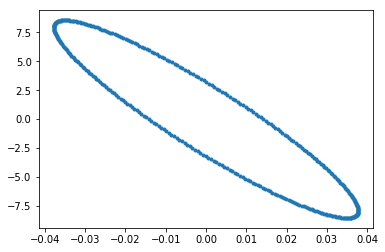

CPU times: user 495 ms, sys: 760 ms, total: 1.26 s
Wall time: 2.39 s


In [14]:
%%time
tofwidths = use_covmat.tofwidths(P=10, M=8)
beamdivs = use_covmat.beamdivs(theta=0.01, phi=0.01)
samplethickness = 0.001
ellipsoid_trace, mR, lambdas = use_covmat.compute(
# cm_res = use_covmat.compute(
    sampleyml, Ei, dynamics, scan,
    instrument, pixel,
    tofwidths, beamdivs, samplethickness,
    plot=True)
# ellipsoid_trace = cm_res['u']

# Use Res Comps

In [15]:
!mcvine-neutron-storage-count-neutrons /SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/out/neutrons

240459


In [16]:
rm -rf out.res_comps_tmp/

In [17]:
beam = "/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9"
psi_axis = scan
use_res_comps.setup(
    'out.res_comps_tmp', sampleyml, beam, dynamics.E, dynamics.hkl0, dynamics.hkl_dir,
    psi_axis, instrument, pixel)

Ei=126.211753632, t0=16.0728240277
Computed:
* psi=6.74520975278 degree
* Q=[ 0.70472623 -5.95846968  0.        ]
* hkl2Qmat=[[-0.73798758  6.23969486  0.        ]
 [ 0.          0.          6.28318531]
 [ 6.23969486  0.73798758  0.        ]]
* ki=7.80444915794
* vectors ki=[ 7.80444916  0.          0.        ], kf=[ 7.09972293  5.95846968  0.        ]
These two numbers should be very close:
  -51.8030461602
  -51.8030461602
  Ei=126.211753632, Ef=178.014799792
* Ef=178.014799792
* pixel positon=[ 2.29795884  1.92857076  0.        ]
* pixel_position=[ 2.29795884  1.92857076  0.        ]
t_m2s=0.00278375914959, t_s2p=0.000514068579162, t_m2p=0.00329782772875


In [18]:
ls out.res_comps_tmp/

run.py  sample/


In [19]:
cat out.res_comps_tmp/run.py

#!/usr/bin/env python
import mcvine.cli
from numpy import array
from mcvine_workflow.singlextal.resolution import use_res_comps as urc
beam_neutrons_path = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/out/neutrons'
instrument = urc.instrument('ARCS', '3.*meter', '13.6*meter', '-0.15*meter')
samplexmlpath = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/6-check-simple-cases-1/out.res_comps_tmp/sample/sampleassembly.xml'
psi = 0.11772611892360563
hkl2Q = array([[-0.73798758,  6.23969486,  0.        ],
       [ 0.        ,  0.        ,  6.28318531],
       [ 6.23969486,  0.73798758,  0.        ]])
pp = array([ 2.29795884,  1.92857076,  0.        ])
pixel = urc.pixel('0.5*inch', 'meter/128', '10*atm', position=(pp[1], pp[2], pp[0]))
t_m2p = 0.0032978277287488969
Q = array([ 0.70472623, -5.95846968,  0.        ])
E = -51.80304616018887
hkl_projection = array([ 1.,  0.,  0.])
urc.run(
    beam_neutrons_path, instr

In [20]:
%%time
%cd {workdir}/out.res_comps_tmp/
!python run.py >log.run
%cd {workdir}

/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/6-check-simple-cases-1/out.res_comps_tmp
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/SimulationContext.py:39: UserWarning: output directory was not set
  warnings.warn("output directory was not set")
/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/notebooks/6-check-simple-cases-1
CPU times: user 554 ms, sys: 181 ms, total: 735 ms
Wall time: 30.2 s


In [21]:
ls out.res_comps_tmp/

dEs.npy  dhkls.npy  dxs.npy  log.run  probs.npy  res.h5  run.py  sample/


In [22]:
res = hh.load('out.res_comps_tmp/res.h5')

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


In [23]:
q = res.x
E = res.E
dE = E[1]-E[0]
dq = q[1]-q[0]
Eg, qg = np.mgrid[slice(E[0], E[-1]+dE/2, E[1]-E[0]), slice(q[0], q[-1]+dq/2, q[1]-q[0])]

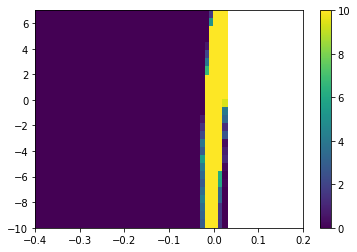

In [24]:
# plt.figure(figsize=(4,6))
plt.pcolormesh(qg, Eg, res.I.T, cmap='viridis')
plt.clim(0, 10)
plt.xlim(-0.4,0.2)
plt.ylim(-10,7)
plt.colorbar()
# plt.plot(u[:, 0], u[:, 1], '.')

## Get mcvine-simulated data

In [25]:
dhkls = np.load('out.res_comps_tmp/dhkls.npy')
dEs = np.load('out.res_comps_tmp/dEs.npy')
probs = np.load('out.res_comps_tmp/probs.npy')

In [26]:
dhs,dks,dls = dhkls.T

## get slice of resolution 

In [27]:
mask=(dls<0.02)*(dls>-0.02)*(dks<0.02)*(dks>-0.02)

hist, qedges, Eedges = np.histogram2d(
    x=dhs[mask], y=dEs[mask], bins=(np.arange(-0.2, 0.2, 0.002), np.arange(-15,8,0.1)), weights=probs[mask])

qaxis = H.axis('q', boundaries=qedges)
Eaxis = H.axis('E', boundaries=Eedges)
IqE = H.histogram('IqE', (qaxis, Eaxis), data=hist)

plot z in (0.0, 14.9516122388)


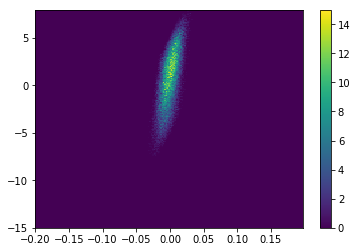

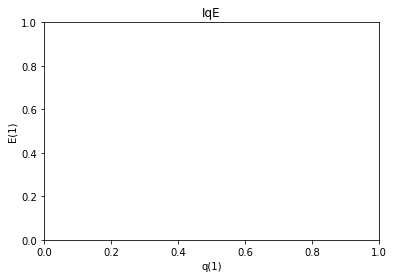

In [28]:
H.plot(IqE)

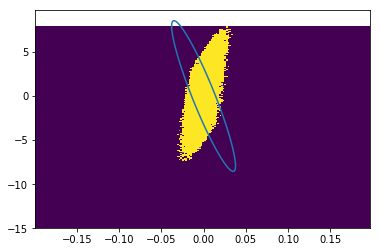

In [29]:
qgrid, Egrid = np.mgrid[
    IqE.q[0] : IqE.q[-1]+1e-10 : IqE.q[1]-IqE.q[0],
    IqE.E[0] : IqE.E[-1]+1e-10 : IqE.E[1]-IqE.E[0]
]
plt.pcolormesh(qgrid, Egrid, IqE.I)
plt.clim(0, 1e-2)
plt.plot(ellipsoid_trace[:,0], ellipsoid_trace[:,1])

# Debugging - skip this

In [65]:
!cp ../4-explore_bad_point-slicing-point2/use_covmat.py .
!cp ../4-explore_bad_point-slicing-point2/solve_psi.py .

In [117]:
!diff use_covmat.py ../4-explore_bad_point-slicing-point2/use_covmat.py

340,342d339
<     print "***dx2dhkl=%s", dx2dhkl
<     print "***hkl2Q_mat=%s", hkl2Q_mat
<     print "***dx2dQ=%s", dx2dQ
367c364
<     print "***N=", N
---
>     # print N


In [118]:
import use_covmat
reload(use_covmat)

<module 'use_covmat' from 'use_covmat.py'>

# Plot along 3 directions

In [30]:
%%time
"""
tofwidths = use_covmat.tofwidths(P=10, M=2)
beamdivs = use_covmat.beamdivs(theta=0.05, phi=0.05)
samplethickness = 0.0001
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "11.7*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )
"""
unit_vectors = [[1,0,0], [0,1,0], [0,0,1]]
axes = 'hkl'

traces = []
IqEs = []
for axis_index, uv in enumerate(unit_vectors):
    dynamics.hkl_dir = np.array(uv)
    ellipsoid_trace, mR, lambdas = use_covmat.compute(
    # cm_res = use_covmat.compute(
        sampleyml, Ei, dynamics, scan,
        instrument, pixel,
        tofwidths, beamdivs, samplethickness,
        plot=False)
    # ellipsoid_trace = cm_res['u']
    traces.append(ellipsoid_trace)
    
    mask = True
    for axis_index2, axis in enumerate(axes):
        if axis_index2==axis_index: continue # skip the axis of interest
        # print "d%ss<0.02"%axis, "d%ss>-0.02"%axis
        mask *= eval("d%ss<0.01"%axis)*eval("d%ss>-0.01"%axis)
        continue
    # print mask.shape, mask.sum(), mask.dtype
    dqs = eval("d%ss" % axes[axis_index])
    hist, qedges, Eedges = np.histogram2d(
        x=dqs[mask], y=dEs[mask], bins=(np.arange(-0.2, 0.2, 0.002), np.arange(-15,8,0.1)), weights=probs[mask])
    # hist, qedges, Eedges = np.histogram2d(
    #    x=dqs, y=dEs, bins=(np.arange(-0.2, 0.2, 0.002), np.arange(-15,8,0.1)), weights=probs)
    qaxis = H.axis('q', boundaries=qedges)
    Eaxis = H.axis('E', boundaries=Eedges)
    # print hist.sum()
    IqE = H.histogram('IqE', (qaxis, Eaxis), data=hist)
    IqEs.append(IqE)
    continue

psi=6.75090167372, Q=[ 0.70531815 -5.95839964  0.        ]
hkl2Q=array([[-0.73860744,  6.23962151,  0.        ],
       [ 0.        ,  0.        ,  6.28318531],
       [ 6.23962151,  0.73860744,  0.        ]])
(Q = hkl dot hkl2Q)
6.0
7.79789939468
[ 7.09258124  5.95839964  0.        ]
ti= 2364.69322632
tf= 514.374601753
R= 3.0
Q= [ 0.70531815 -5.95839964  0.        ]
eeta= -1.45297086511
psi=6.75090167372, Q=[ 0.70531815 -5.95839964  0.        ]
hkl2Q=array([[-0.73860744,  6.23962151,  0.        ],
       [ 0.        ,  0.        ,  6.28318531],
       [ 6.23962151,  0.73860744,  0.        ]])
(Q = hkl dot hkl2Q)
6.0
7.79789939468
[ 7.09258124  5.95839964  0.        ]
ti= 2364.69322632
tf= 514.374601753
R= 3.0
Q= [ 0.70531815 -5.95839964  0.        ]
eeta= -1.45297086511
psi=6.75090167372, Q=[ 0.70531815 -5.95839964  0.        ]
hkl2Q=array([[-0.73860744,  6.23962151,  0.        ],
       [ 0.        ,  0.        ,  6.28318531],
       [ 6.23962151,  0.73860744,  0.        ]])
(Q = hkl

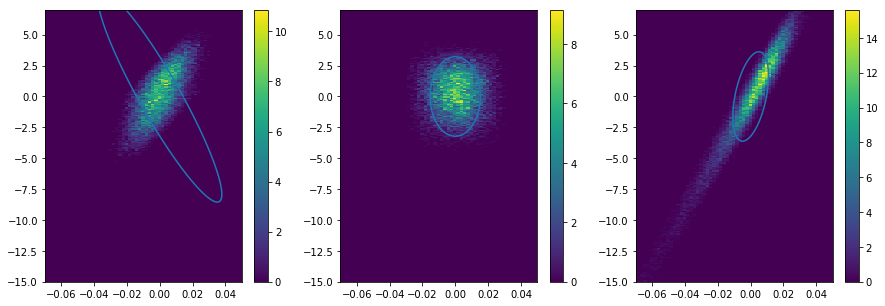

In [31]:
plt.figure(figsize=(15, 5))
for i, (trace, IqE) in enumerate(zip(traces, IqEs)):
    plt.subplot(1, 3, i+1)
    qgrid, Egrid = np.mgrid[
        IqE.q[0] : IqE.q[-1]+1e-10 : IqE.q[1]-IqE.q[0],
        IqE.E[0] : IqE.E[-1]+1e-10 : IqE.E[1]-IqE.E[0]
    ]
    plt.pcolormesh(qgrid, Egrid, IqE.I)
    #plt.clim(0, 1e-1)
    plt.colorbar()
    plt.plot(trace[:,0], trace[:,1])
    plt.xlim(-0.07, 0.05)
    plt.ylim(-15, 7)

## Rouch estimate
Only concern with main correlation resulting from spread of incident energy

$\because$
Q = ki - kf

$\therefore$
dQ = dki

$\because$
E = Ei - Ef

$\therefore$
dE = dEi

$\because$
ki along z

$\therefore$
dQz = dki

$\frac{ki^2}{2m} = Ei$

$2\frac{dki}{ki} = \frac{dEi}{Ei}$

$\frac{dQz}{dE} = \frac{ki}{2Ei}$



In [32]:
slope = ki/2./Ei/2/np.pi  # 2pi convert Q to l
print slope

0.00492489775554


slope from plot

In [33]:
(0.025-(-0.06))/(7-(-14))

0.004047619047619047